In [2]:
import torch
import matplotlib.pyplot as plt
from models import *
from utils import show_images, get_noise

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ppvalluri09/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
generator = Generator(z_dim=64, im_channels=3, hidden_dim=64).to(device)
classifier = Classifier(num_classes=40).to(device)

In [5]:
gen_dict = torch.load("./models/generator.pth", map_location=torch.device("cpu"))["gen"]
generator.load_state_dict(gen_dict)
# setting to evaluate mode, so that our gradients don't get computed
generator.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [6]:
clf_dict = torch.load("./models/classifier.pth", map_location=torch.device("cpu"))["classifier"]
classifier.load_state_dict(clf_dict)
classifier.eval()

Classifier(
  (classifier): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 40, kernel_size=(4, 4), stride=(2, 2))
    )
  )
)

In [7]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)

In [8]:
def calc_grasc_noise(noise, weight):
    new_noise = noise + (noise.grad*weight)
    return new_noise

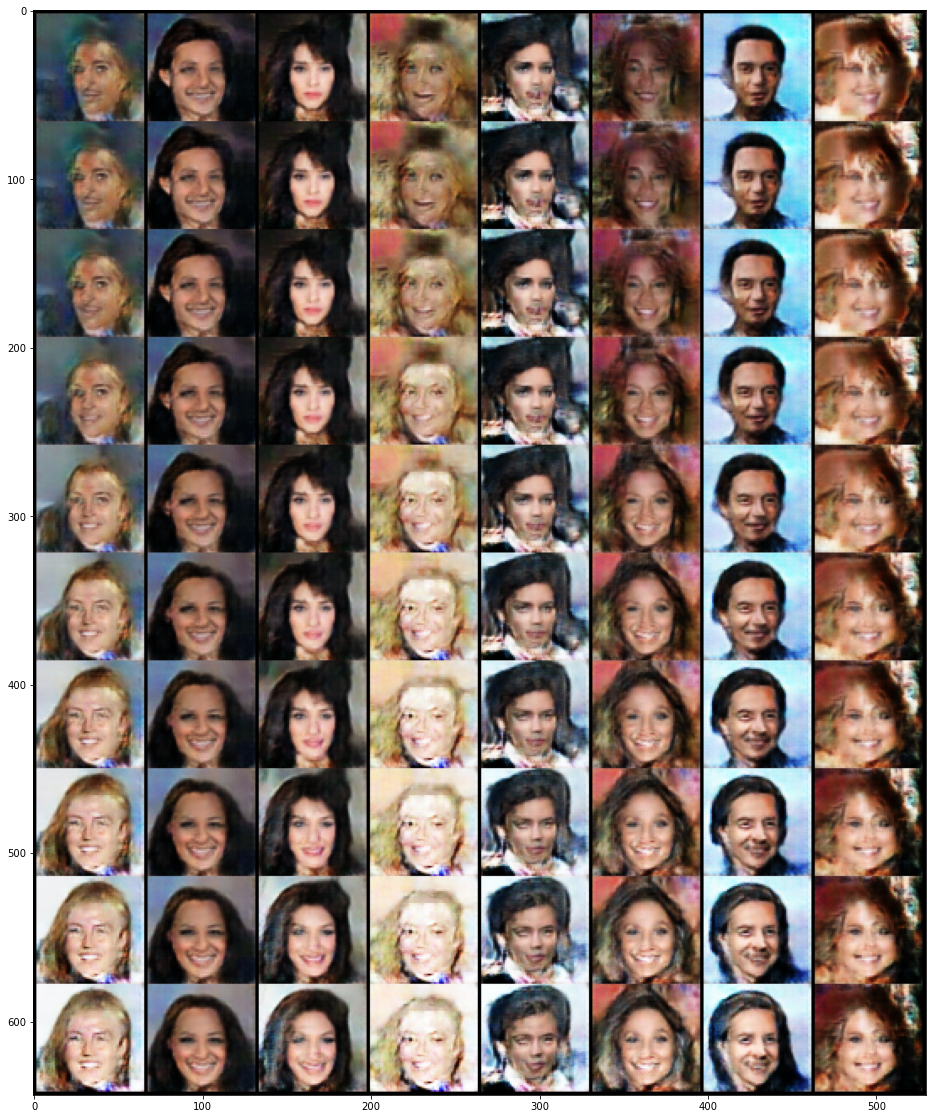

In [13]:
num_images = 8
fake_images = []
grad_steps = 20
skip = 2

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]


target_indices = feature_names.index("Smiling")

noise = get_noise(num_images, z_dim=64).to(device).requires_grad_()
for i in range(grad_steps):
    optimizer.zero_grad()
    fake = generator(noise)
    fake_images += [fake]
    score = classifier(fake)[:, target_indices].mean()
    score.backward()
    noise.data = calc_grasc_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [num_images * 2, grad_steps * 2]
show_images(torch.cat(fake_images[::skip], dim=2), num_images=num_images, nrow=num_images)